# Papers

1D CNNs https://arxiv.org/pdf/1905.03554.pdf

DNN review https://arxiv.org/pdf/1901.06032.pdf


visualize features https://cs.nyu.edu/~fergus/papers/zeilerECCV2014.pdf

grad cam

AlexNet https://proceedings.neurips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf


LeNet http://LeNetvision.stanford.edu/cs598_spring07/papers/Lecun98.pdf

LeNet implementation : Grokking deep learning for computer vision
https://livebook.manning.com/book/grokking-deep-learning-for-computer-vision/chapter-5/v-3/23

Automated spectroscopic modelling with optimised convolutional neural networks: https://www.nature.com/articles/s41598-020-80486-9

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
@author: M Arshad Zahangir Chowdhury

Use a 1D convolutional neural network to train and test on simulated THz spectra. 



"""

%matplotlib inline 

import sys
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import signal
from ipywidgets import interactive
import seaborn as sns  #heat map
import glob # batch processing of images

if '../../' not in sys.path:
    sys.path.append('../../')

import math
from scipy import signal
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve 
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score

import itertools

from vocnet.misc.utils import classifier_internals, clf_post_processor


from vocnet.spectral_datasets.IR_datasets import IR_data, spectra_to_img
from vocnet.spectral_datasets.THz_datasets import THz_data

from vocnet.misc.aperture import publication_fig


# tensorflow loadings

In [2]:
#Allocate memory 
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

GPU_mem_limit=1.0
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=GPU_mem_limit*1000.0)])

    except RuntimeError as e:
        print(e)        

        #Set random seed
#Set random seed
os.environ['PYTHONHASHSEED'] = str(42)
tf.random.set_seed(42)  
np.random.seed(42)

2022-06-21 17:46:03.309906: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-06-21 17:46:04.203721: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-06-21 17:46:04.234728: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:65:00.0 name: Quadro RTX 4000 computeCapability: 7.5
coreClock: 1.545GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 387.49GiB/s
2022-06-21 17:46:04.234820: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-06-21 17:46:04.240235: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-06-21 17:46:04.240317: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so

# functions and class definitions should be here and moved

In [3]:


# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, target, average="macro", figsize = (12, 8), dpi=300 ):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    
    fig, c_ax = plt.subplots(1,1, figsize = figsize, dpi=dpi)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')    
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')

    plt.close()
    
    return roc_auc_score(y_test, y_pred, average=average), fig, c_ax



In [4]:
def plot_raw_scores(i, predictions_array, true_label, all_unique_labels, 
                    fig_prop = {'figsize':(2,0.7), 'dpi':300, 'ax_rect': [0,0,1,1]}
                   ):
    fig = plt.figure(figsize=fig_prop['figsize'],dpi=fig_prop['dpi'])
    ax = fig.add_axes(fig_prop['ax_rect'])
    
    true_label = true_label[i]
    plt.grid(False)
    plt.xticks(range(12),all_unique_labels)
    plt.yticks([])
    thisplot = plt.bar(range(12), predictions_array[i], color="#777777")
    plt.ylim([0, 1])
    ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.2))
    predicted_label = np.argmax(predictions_array[i])
    
    ax.set_xticklabels(s.labels);
    ax.set_xlabel('Labels', labelpad = 4, 
                  fontsize = 'small', 
                  fontweight = 'bold')
    ax.set_ylabel('Softmax scores', labelpad = 4, 
                  fontsize = 'small', 
                  fontweight = 'bold')
    ax.xaxis.set_tick_params(which='major', 
                             size=5, 
                             width=1, 
                             direction='out',
                             labelsize=7)
    ax.yaxis.set_tick_params(which='major', 
                             size=5, 
                             width=1, 
                             direction='out',
                             labelsize=7)
    
    
    
    plt.xticks(rotation=90, fontweight='bold');

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')
    plt.close()
    return fig, ax

In [5]:
def simple_spectrum_fig(frequencies, absorbances):
    
    spectrum_plot = plt.plot(frequencies, absorbances/max(absorbances), linewidth = 0.5, color = 'black')
    plt.xlabel('Frequency ($cm^{-1}$)')
    plt.ylabel('Norm. Abs.')
    plt.xlim([frequencies[0], frequencies[-1]])
    
def simple_plot_raw_scores(i, predictions_array, true_label,all_unique_labels):
    
    true_label = true_label[i]
    plt.grid(False)
    plt.yticks(range(12),all_unique_labels)

    scoreplot = plt.barh(range(12), predictions_array[i], color="#777777")
    
    plt.xlim([0, 1])
    predicted_label = np.argmax(predictions_array[i])
    plt.yticks(fontsize = 7);
    plt.tick_params(axis = 'y', direction = 'out') # , pad =-335
    
    plt.ylabel('label')
    plt.xlabel('softmax score')
    scoreplot[predicted_label].set_color('red')
    scoreplot[true_label].set_color('blue')
    
    
    

## load THz spectra

In [6]:
s = THz_data(resolution=0.016, verbosity = False)

In [7]:
s.load_THz_data()

## attributes of the THz dataset

In [8]:
s.dataset_info()


 no. of discarded rows 22

 samplesize (no. of sampling points) 229

 labels of molecules present 
 ['CH3Cl', 'CH3OH', 'HCOOH', 'H2CO', 'H2S', 'SO2', 'OCS', 'HCN', 'CH3CN', 'HNO3', 'C2H5OH', 'CH3CHO']

 target indices (integers) of molecules present [ 0  0  0 ... 11 11 11]

 frequencies present in the data 
  [ 7.352  7.368  7.384  7.4    7.416  7.432  7.448  7.464  7.48   7.496
  7.512  7.528  7.544  7.56   7.576  7.592  7.608  7.624  7.64   7.656
  7.672  7.688  7.704  7.72   7.736  7.752  7.768  7.784  7.8    7.816
  7.832  7.848  7.864  7.88   7.896  7.912  7.928  7.944  7.96   7.976
  7.992  8.008  8.024  8.04   8.056  8.072  8.088  8.104  8.12   8.136
  8.152  8.168  8.184  8.2    8.216  8.232  8.248  8.264  8.28   8.296
  8.312  8.328  8.344  8.36   8.376  8.392  8.408  8.424  8.44   8.456
  8.472  8.488  8.504  8.52   8.536  8.552  8.568  8.584  8.6    8.616
  8.632  8.648  8.664  8.68   8.696  8.712  8.728  8.744  8.76   8.776
  8.792  8.808  8.824  8.84   8.856  8.872  8.888

## visualize the THz spectra

In [9]:
def f_spectra(spectra_no):
    plt.plot(s.frequencies, s.spectra[spectra_no]); #reshape needed so you have 367 datapoints.
#     plt.ylim(-0.5, 5)
    plt.grid(True)
    plt.show()

interactive_plot = interactive(f_spectra, spectra_no=(0, s.spectra.shape[0]-1))
output = interactive_plot.children[-1]
interactive_plot

interactive(children=(IntSlider(value=983, description='spectra_no', max=1967), Output()), _dom_classes=('widg…

# choose amount of data

In [10]:

s.filter_by_index(0,51)

X_filtered=s.filtered_spectra
y_filtered=s.filtered_targets

## Assigning the data to the model
expand the dimension of the data 


In [11]:
X = s.spectra
y = s.targets

# X = X_filtered
# y = y_filtered

In [12]:
X.shape

(1968, 229)

In [13]:
X=np.expand_dims(X,-1)

In [14]:
X.shape

(1968, 229, 1)

In [15]:
#split intro train and test set

#seeds used 123,237, 786
from sklearn.model_selection import train_test_split

TRAIN_SIZE=0.70
TEST_SIZE=1-TRAIN_SIZE

x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=TRAIN_SIZE,
                                                   test_size=TEST_SIZE,
                                                   random_state=786,
                                                   stratify=y
                                                   )

print("All:", np.bincount(y) / float(len(y))*100  )
print("Training:", np.bincount(y_train) / float(len(y_train))*100  )
print("Testing:", np.bincount(y_test) / float(len(y_test))*100  )


All: [8.33333333 8.33333333 8.33333333 8.33333333 8.33333333 8.33333333
 8.33333333 8.33333333 8.33333333 8.33333333 8.33333333 8.33333333]
Training: [8.35148874 8.35148874 8.35148874 8.35148874 8.35148874 8.35148874
 8.35148874 8.2788671  8.35148874 8.35148874 8.2788671  8.2788671 ]
Testing: [8.29103215 8.29103215 8.29103215 8.29103215 8.29103215 8.29103215
 8.29103215 8.46023689 8.29103215 8.29103215 8.46023689 8.46023689]


## define 1D CNN model architecture

In [16]:
s.samplesize

229

## TO-DO: Is the last layer "soft max" activated?

## Calculate the probability scores.

## Create same network in Torch and check consistency.

## Interpret the tensors in every layer.

# Choosing the model architecture. Justification needed for every layer and each layer's hyperparameters. Survey the common DNNs both 2D and 1D. USe keras autotuner.

# write a wrapper function around tensorflow to define model and keep the data. use *kwargs

# softmax scores. GET THEM

### read geron book in detail

### Find out how many spectra are required for training


In [17]:
### 

# Create model via a sequential stack of layers using the layers API with the add() method

In [18]:
def simplest_model():

    model = models.Sequential()

    # C1 Convolutional Layer
    model.add(layers.Conv1D(filters = 1 , kernel_size=3, activation='relu', input_shape=(229, 1), name = 'C1') )

    # S2 Subsampling Layer
    model.add(layers.AveragePooling1D(pool_size = 2, strides = 2, padding = 'valid', name = 'S2'))

    # Flatten the CNN output to feed it with fully connected layers
    model.add(layers.Flatten())
    
    # model.add(layers.Dense(48, activation='relu')) # tanh yielded good result
    model.add(layers.Dense(12))  # number of dense layer would be equal to number of classess
    model.summary()
    
    return model


In [19]:
def multi_conv_model():

    model = models.Sequential()

    # C1 Convolutional Layer
    model.add(layers.Conv1D(filters = 1 , kernel_size=3, activation='relu', input_shape=(229, 1), name = 'C1') )

    # S2 Subsampling Layer
    model.add(layers.AveragePooling1D(pool_size = 2, strides = 2, padding = 'valid', name = 'S2'))
    
    # C3 Convolutional Layer
    model.add(layers.Conv1D(filters = 1 , kernel_size=3, activation='relu', name = 'C3') )

    # Flatten the CNN output to feed it with fully connected layers
    model.add(layers.Flatten())
    
    # model.add(layers.Dense(48, activation='relu')) # tanh yielded good result
    model.add(layers.Dense(12))  # number of dense layer would be equal to number of classess
    model.summary()
    
    return model

In [20]:
def multi_conv_with_dense_model():

    model = models.Sequential()

    # C1 Convolutional Layer
    model.add(layers.Conv1D(filters = 1 , kernel_size=3, activation='relu', input_shape=(229, 1), name = 'C1') )

    # S2 Subsampling Layer
    model.add(layers.AveragePooling1D(pool_size = 2, strides = 2, padding = 'valid', name = 'S2'))
    
    # C3 Convolutional Layer
    model.add(layers.Conv1D(filters = 1 , kernel_size=3, activation='relu', name = 'C3') )

    # Flatten the CNN output to feed it with fully connected layers
    model.add(layers.Flatten())
    
    model.add(layers.Dense(48, activation='relu')) # tanh yielded good result
    model.add(layers.Dense(12))  # number of dense layer would be equal to number of classess
    model.summary()
    
    return model

In [21]:
# class Model_builder():
    
        
#     def __init__(self,  **kwargs):
        
#         self.model_name = self.kwargs.pop('model_name')
        
#     def model_info(self):
#         print(self.model_name)

In [22]:
# select model
model = multi_conv_model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
C1 (Conv1D)                  (None, 227, 1)            4         
_________________________________________________________________
S2 (AveragePooling1D)        (None, 113, 1)            0         
_________________________________________________________________
C3 (Conv1D)                  (None, 111, 1)            4         
_________________________________________________________________
flatten (Flatten)            (None, 111)               0         
_________________________________________________________________
dense (Dense)                (None, 12)                1344      
Total params: 1,352
Trainable params: 1,352
Non-trainable params: 0
_________________________________________________________________


2022-06-21 17:46:23.556497: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-21 17:46:23.557999: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:65:00.0 name: Quadro RTX 4000 computeCapability: 7.5
coreClock: 1.545GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 387.49GiB/s
2022-06-21 17:46:23.559921: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1871] Adding visible gpu devices: 0
2022-06-21 17:46:23.560092: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-06-21 17:46:23.992136: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1258] Device interconnect Str

In [23]:
# # base model for prototyping

# model = models.Sequential()

# # C1 Convolutional Layer
# model.add(layers.Conv1D(filters = 1 , kernel_size=5, activation='relu', input_shape=(229, 1), name = 'C1') )

# # S2 Subsampling Layer
# model.add(layers.AveragePooling1D(pool_size = 2, strides = 2, padding = 'valid', name = 'S2'))




# # model.add(layers.Dropout(rate = 0.1, seed = 786))

# # Flatten the CNN output to feed it with fully connected layers
# model.add(layers.Flatten())
# # model.add(layers.Dense(48, activation='relu')) # tanh yielded good result
# model.add(layers.Dense(12))  # number of dense layer would be equal to number of classess
# model.summary()

In [24]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=15, 
                    validation_data=(x_test, y_test))


2022-06-21 17:46:25.559643: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-06-21 17:46:25.576678: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3600000000 Hz


Epoch 1/15


2022-06-21 17:46:25.885017: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2022-06-21 17:46:26.132467: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8204
2022-06-21 17:46:26.594068: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11


 1/44 [..............................] - ETA: 1:10 - loss: 2.4848 - accuracy: 0.0312

2022-06-21 17:46:27.077157: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


44/44 [==============================] - 2s 10ms/step - loss: 2.4829 - accuracy: 0.1264 - val_loss: 2.4727 - val_accuracy: 0.2149
Epoch 2/15
44/44 [==============================] - 0s 6ms/step - loss: 2.4492 - accuracy: 0.1939 - val_loss: 2.4127 - val_accuracy: 0.1455
Epoch 3/15
44/44 [==============================] - 0s 6ms/step - loss: 2.3861 - accuracy: 0.1046 - val_loss: 2.3376 - val_accuracy: 0.1083
Epoch 4/15
44/44 [==============================] - 0s 6ms/step - loss: 2.3004 - accuracy: 0.3406 - val_loss: 2.2305 - val_accuracy: 0.5364
Epoch 5/15
44/44 [==============================] - 0s 6ms/step - loss: 2.1683 - accuracy: 0.5904 - val_loss: 2.0459 - val_accuracy: 0.7699
Epoch 6/15
44/44 [==============================] - 0s 6ms/step - loss: 1.9189 - accuracy: 0.8090 - val_loss: 1.7032 - val_accuracy: 0.9306
Epoch 7/15
44/44 [==============================] - 0s 6ms/step - loss: 1.5346 - accuracy: 0.8170 - val_loss: 1.2801 - val_accuracy: 0.9120
Epoch 8/15
44/44 [============

In [190]:
from tensorflow.keras import regularizers
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

In [191]:
from  IPython import display

import pathlib
import shutil
import tempfile

In [192]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)


In [ ]:
FEATURES = 28


In [137]:
model.layers[0].trainable_weights

[<tf.Variable 'C1/kernel:0' shape=(5, 1, 1) dtype=float32, numpy=
 array([[[-0.2526946 ]],
 
        [[ 0.63842565]],
 
        [[ 0.96369314]],
 
        [[ 1.3211755 ]],
 
        [[ 1.2555256 ]]], dtype=float32)>,
 <tf.Variable 'C1/bias:0' shape=(1,) dtype=float32, numpy=array([0.00410771], dtype=float32)>]

In [138]:
from tensorflow.keras import backend as K
# with a Sequential model
get_1st_layer_output = K.function([model.layers[0].input],
                                  [model.layers[1].output])
# layer_output = get_1st_layer_output(x_test)
layer_output = get_1st_layer_output(X)

In [139]:
model.layers[0].get_config()

{'name': 'C1',
 'trainable': True,
 'batch_input_shape': (None, 229, 1),
 'dtype': 'float32',
 'filters': 1,
 'kernel_size': (5,),
 'strides': (1,),
 'padding': 'valid',
 'data_format': 'channels_last',
 'dilation_rate': (1,),
 'groups': 1,
 'activation': 'relu',
 'use_bias': True,
 'kernel_initializer': {'class_name': 'GlorotUniform',
  'config': {'seed': None}},
 'bias_initializer': {'class_name': 'Zeros', 'config': {}},
 'kernel_regularizer': None,
 'bias_regularizer': None,
 'activity_regularizer': None,
 'kernel_constraint': None,
 'bias_constraint': None}

In [140]:
layer_output[0].shape

(1968, 112, 1)

In [141]:
layer_output[0][0].shape

(112, 1)

In [142]:
layer_output[0][0].shape

(112, 1)

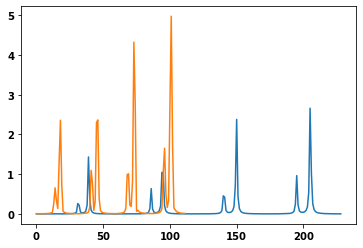

In [152]:
j=0
plt.plot(X[j])
plt.plot(layer_output[0][j])

# training accuracies vs epoch

19/19 - 0s - loss: 0.3978 - accuracy: 0.9898


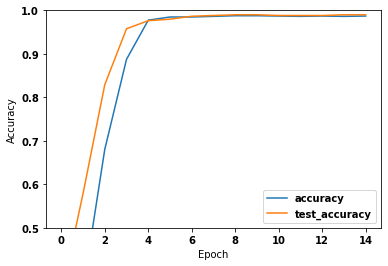

In [153]:
# model.save('VOCNet')
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'test_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)

In [154]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)

print('\nTest accuracy:', test_acc)

train_loss, train_acc = model.evaluate(x_train, y_train, verbose=2)

print('\nTrain accuracy:', train_acc)

19/19 - 0s - loss: 0.3978 - accuracy: 0.9898

Test accuracy: 0.989847719669342
44/44 - 0s - loss: 0.4084 - accuracy: 0.9862

Train accuracy: 0.9862018823623657


The model has achieved 100% accuracy. which is good but I wonder whether it is overfitting. I need to check and verify this. But first check the scores.

In [155]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

In [156]:
predictions = probability_model.predict(x_test)


In [157]:
predictions[5]

array([0.01963932, 0.06118127, 0.6741734 , 0.02113709, 0.01178556,
       0.04376858, 0.02534869, 0.01276763, 0.01182437, 0.0196693 ,
       0.06700216, 0.03170251], dtype=float32)

9


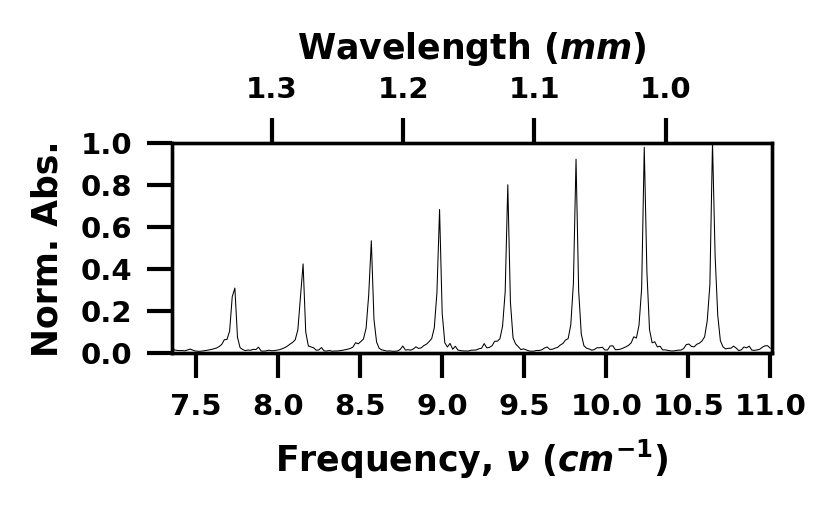

In [158]:

# high quality
i=4;

fig_score, ax_score = plot_raw_scores(i, predictions, y_test, s.labels)
fig_spectra, ax_spectra  = publication_fig(s.frequencies, 
                   x_test[i], 
                   xlim_low=s.frequencies[0],
                   xlim_high=s.frequencies[-1]+0.01, 
                   ylim_low=0,
                   ylim_high=1.00,
                   fig_prop = {'figsize':(2,0.7), 'dpi':300, 'ax_rect': [0,0,1,1]},
                   plot_prop = {'linewidth':0.25, 'color':'black' , 'fontweight':'bold', 'label' : 'compound'},
                   legend_prop = {'loc':2, 'size':3},
                   major_tick_params =  {'which':'major', 'size':6, 'width':1, 'direction':'out','labelsize':7},
                   minor_tick_params =  {'which':'minor', 'size':2, 'width':1, 'direction':'out','labelsize':7},
                   tick_locator = {'xmajor':0.5, 'xminor':1.5, 'ymajor':0.2, 'yminor':0.4},
                   xlabelinfo = {'xlabel': r'Frequency, $\nu$ ($cm^{-1}$)', 'labelpad':4, 'fontsize':'small', 'fontweight':'bold'}, 
                   ylabelinfo = {'ylabel': r'Norm. Abs.', 'labelpad':4, 'fontsize':'small', 'fontweight':'bold'},
                   twin_xlabelinfo = {'xlabel': 'Wavelength ($mm$)', 'labelpad':4, 'fontsize':'small', 'fontweight':'bold'}, 
                   plot_flags = {'twinx': True, 'legend':False}
                   );


print(y_test[i])

fig_score
fig_spectra

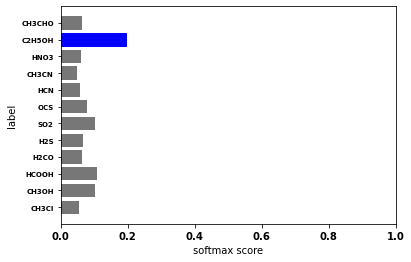

In [159]:
i=3
# simple_spectrum_fig(s.frequencies, x_test[i])
simple_plot_raw_scores(i, predictions, y_test,s.labels)

In [160]:
# Plot the first X test spectra, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.

def plot_sequential_group_prediction(x,y, predictions, start=0):
    num_rows = 4
    num_cols = 3
    num_images = num_rows*num_cols
    plt.figure(figsize=(2*2*num_cols, 2*num_rows),dpi=300)

    if start<0:
        start=0

    for i in range(num_images):
        plt.subplot(num_rows, 2*num_cols, 2*i+1)
        simple_spectrum_fig(s.frequencies, x[i+int(start)])
        plt.subplot(num_rows, 2*num_cols, 2*i+2)
        simple_plot_raw_scores(i+int(start), predictions, y,s.labels)
    plt.tight_layout()
    plt.show()

In [161]:
plot_sequential_group_prediction(x_test, y_test, predictions, 0)

In [162]:
plot_sequential_group_prediction(x_test, y_test, predictions, 50)

# Make predictions and plot confusion matrix

In [163]:
# make predictions
pred_y=np.argmax(model.predict(x_test), axis=-1)

In [164]:
# clf_post_processor(rounded_pred_y, y_test, s.labels, cm_title='Confusion matrix CNN on IR Data', cmap_color='crest', verbose = True)

In [165]:
cm = confusion_matrix(y_test, pred_y)
#print(cm)
fig = plt.figure(figsize=(16,10), dpi = 600);
plt.title('Confusion matrix 1D CNN on THz Data');
ax = sns.heatmap(cm, annot=True, cmap='PiYG');   #cmap='coolwarm' also good
#ax = sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues') #Shows percentage
ax.set_xticklabels(s.labels);
ax.set_yticklabels(s.labels);
plt.xlabel('Predicted Molecule');
plt.ylabel('Actual Moelcule');
plt.xticks(rotation=90);
plt.yticks(rotation=0);

## Specifically identify the misclassifications. Need to check if model is overfitting or underfitting

In [166]:
classifier_internals(pred_y, y_test, y_train, 'simple_CNN')

---------------------------- simple_CNN -------------------------------
Fraction Correct[Accuracy]:
0.9898477157360406
Samples Correctly Classified:
(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 1

In [167]:
plot_sequential_group_prediction(x_test, y_test, predictions, 440)

# ROC Curve

In [168]:
s.labels

['CH3Cl',
 'CH3OH',
 'HCOOH',
 'H2CO',
 'H2S',
 'SO2',
 'OCS',
 'HCN',
 'CH3CN',
 'HNO3',
 'C2H5OH',
 'CH3CHO']

# ROC on simulation

In [182]:

print('ROC AUC score:', multiclass_roc_auc_score(y_test, pred_y, s.labels)[0])

multiclass_roc_auc_score(y_test, pred_y, s.labels)[1]

ROC AUC score: 0.9944537113738484


### calculate ROC on experiments too

# Add experimental classification and calculation of TPR, FPR etc.  Integrate the CNN classifier to the old THz experimental classification notebook.

In [170]:
s.load_experiments()

Number of Experimental Compounds: 6
Number of Spectrum: 6
Total Number of Spectra: 36
Sample Size of training data: 229
Rows discarded: 22


In [171]:
Xexp = s.exp_spectra
yexp = s.exp_targets

In [172]:
SpectraFrame = pd.DataFrame(s.exp_spectra)
SpectraFrame['labels'] = [s.labels[i] for i in s.exp_targets]
SpectraFrame['targets'] =  s.exp_targets
spectraframe = SpectraFrame 

In [173]:
Xexp = np.expand_dims(Xexp,-1)

In [174]:
pred_y_exp=np.argmax(model.predict(Xexp), axis=-1)

In [175]:
pred_y_exp

array([10, 10, 10, 10, 10, 10,  2,  2,  2,  2,  2,  2,  1,  1,  1,  1,  1,
        1,  0,  0,  0,  2,  0,  0, 10, 10,  8, 10, 10, 10, 11, 11,  1,  1,
        1, 11])

In [176]:
yexp

array([10, 10, 10, 10, 10, 10,  2,  2,  2,  2,  2,  2,  1,  1,  1,  1,  1,
        1,  0,  0,  0,  0,  0,  0,  8,  8,  8,  8,  8,  8, 11, 11, 11, 11,
       11, 11])

In [184]:
s.labels

['CH3Cl',
 'CH3OH',
 'HCOOH',
 'H2CO',
 'H2S',
 'SO2',
 'OCS',
 'HCN',
 'CH3CN',
 'HNO3',
 'C2H5OH',
 'CH3CHO']

In [185]:
s.exp_

array([10, 10, 10, 10, 10, 10,  2,  2,  2,  2,  2,  2,  1,  1,  1,  1,  1,
        1,  0,  0,  0,  0,  0,  0,  8,  8,  8,  8,  8,  8, 11, 11, 11, 11,
       11, 11])

In [183]:
[s.labels[i] for i in s.exp_targets]

['C2H5OH',
 'C2H5OH',
 'C2H5OH',
 'C2H5OH',
 'C2H5OH',
 'C2H5OH',
 'HCOOH',
 'HCOOH',
 'HCOOH',
 'HCOOH',
 'HCOOH',
 'HCOOH',
 'CH3OH',
 'CH3OH',
 'CH3OH',
 'CH3OH',
 'CH3OH',
 'CH3OH',
 'CH3Cl',
 'CH3Cl',
 'CH3Cl',
 'CH3Cl',
 'CH3Cl',
 'CH3Cl',
 'CH3CN',
 'CH3CN',
 'CH3CN',
 'CH3CN',
 'CH3CN',
 'CH3CN',
 'CH3CHO',
 'CH3CHO',
 'CH3CHO',
 'CH3CHO',
 'CH3CHO',
 'CH3CHO']

In [177]:
predictions_exp = probability_model.predict(Xexp) # softmax scores for experiment


In [178]:
# cm = confusion_matrix(yexp, pred_y_exp)
# #print(cm)
# fig = plt.figure(figsize=(16,10), dpi = 600);
# plt.title('Confusion matrix 1D CNN on experimental THz Data');
# ax = sns.heatmap(cm, annot=True, cmap='PiYG');   #cmap='coolwarm' also good
# #ax = sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues') #Shows percentage
# ax.set_xticklabels(s.labels);
# ax.set_yticklabels(s.labels);
# plt.xlabel('Predicted Molecule');
# plt.ylabel('Actual Moelcule');
# plt.xticks(rotation=90);
# plt.yticks(rotation=0);

In [179]:
plot_sequential_group_prediction(Xexp, yexp, predictions_exp, 23)

In [189]:
# import the experimental ROC curves from the THz work.
# print('ROC AUC score:', multiclass_roc_auc_score(yexp, pred_y_exp, s.exp_targets)[0])

multiclass_roc_auc_score(yexp, pred_y_exp, s.labels)[1]

IndexError: index 6 is out of bounds for axis 1 with size 6

# demonstrate overfitting

show simple, moderate and very complex models


# add dropout, early stopping and L2 regualrization to mitigate overfitting and pick model from there

## notebook ends